# Abstract
#### Setting

        1. 1차 정제 데이터인 CAI_data_001.csv  데이터를 사용하여 2차 전처리 진행
        2. 토큰화, 불용어 처리
        3. 사전(vocab) word_to_index 구성
        4. 문장 통계 분석 및 시각화
        5. 모델링

#### Method
        
        1. VOC 유형 중 depth_1 유형을 예측하는 모델
        2. model 폴더에 .h5파일로 모델 저장
        3. 다른 모델(Kobert, Roberta)도 적용 예정

#### Result
        사용 모델 : LSTM
                    loss: 0.5791 - accuracy: 0.8449
                        



                            
                            

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
import timeit

# 한국어 tokenizer
from konlpy.tag import Okt
tokenizer = Okt()
from collections import Counter


In [3]:
df = pd.read_csv("../data/dataset/CAI_data_001.csv")
print("df set: {}개".format(len(df)))

df set: 8186개


In [4]:
df.head(10)

,Label,sentence
0,원인불명>조치 전 자연 회복,고객 요청사 항 안됨상담 중 자연회복됨
1,실시간 채널>네트워크 오류,고객 요청사항 수신불인터넷 연결오류 뜸재부팅해 봄 모텔 영업용 일 중 꼭 점검원하여...
2,실시간 채널>수신 불량,고객 요청사항 수신불회선 단말특이사항 진단 결과 기타 추가 연락처 연후방
3,실시간 채널>네트워크 오류,수신 불 네트워크 오류 접수 보류
4,실시간 채널>수신 불량,고객 요청사항 수신불 연락 후 회선단말특이사항 진단 결과 기타 추가 연락처인 입
5,단말>STB(작동)이상,고객 요청사항 채널은 정상 넷플릭스 안됨 포트리셋 미리 연락 후 방문 요망 회선단말...
6,단말>STB(부팅) 이상>부팅중 오류메시지 발생,고객 요청사항 수신 불 서비스 시작 중 회선 단말특이사항 진단 결과 기타 추가 연락처
7,단말>STB(작동)이상,김현철 채팅 지니 자체에서 잡음이 난다고 함고장 접수 함 고객 요청사항 셋탑이상지니...
8,실시간 채널>음성 이상,고객 요청사항 나오나 따닥거리는 소리가 난다함리셋 후 잘됨회선 단말특이사항 진단 결...
9,VOD/컨텐츠>화질 이상,고객 요청사항 화질 불량 시청 중 멈추는 증상 반복됨 연락 후회선 단말특이사항 진단...


## 2차 데이터 전처리

#### Label 지정 후 정제 (label Encoding) 및 시각화


- 첫 실험을 위해 depth_1을 target으로 지정
- '>' 기호를 기준으로 컬럼을 세개로 나눔

In [5]:
df['depth_1'] = df.Label.str.split('>').str[0]
df['depth_2'] = df.Label.str.split('>').str[1]
df['depth_3'] = df.Label.str.split('>').str[2]

실시간 채널       4046
단말           2460
AS접수/변경       817
고객원인          547
VOD/컨텐츠       123
원인불명           66
장애안내           38
양방향서비스         34
시설관리           21
데이터서비스         19
시설이전            7
부가/지능망서비스       4
지니뮤직            3
리콜/손해배상         1
Name: depth_1, dtype: int64


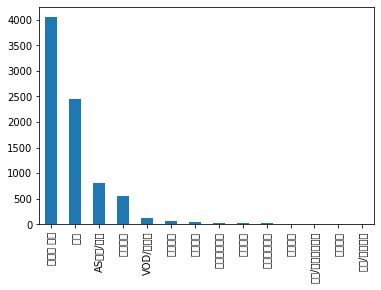

In [6]:
# depth_1 시각화

df['depth_1'].value_counts().plot(kind = 'bar')

###폰트 깨짐 방지###
plt.rc('font', family='Gothic')
plt.rcParams['axes.unicode_minus'] = False
###

#수치로 표현
print(df['depth_1'].value_counts())

수신 불량              2876
리모컨작동불가            1376
STB(작동)이상           770
화질 이상               692
장비리셋 후 재사용 요청       567
부주의, ID/PW 분실 등     418
네트워크 오류             326
임대단말 분실/파손          196
STB(부팅) 이상          163
음성 이상               137
음성인식이상(기가지니)        132
증설/구내선 정리요청         101
메뉴 실행 불가             83
조치 전 자연 회복           66
임대단말 회수요청            54
전환 지연                34
양방향서비스 사용불가          34
네트워크장비 장애            27
특이고장                 19
접속 지연/끊김             19
채널편성표 없음             19
기타 KT시설(상세메모기입)      16
스피커이상(기가지니)           9
타사 및 기타 장애            8
맨홀/전주/단자함/기타          7
전원, 충전 이상             7
AS보류(유료화)             6
이용불가                  4
케이블(전송로) 장애           3
IP 공유기 이상             3
지니뮤직이상(기가지니)          3
맨홀/전주                 3
USB포트 인식 불가           3
PIN 인증 오류             2
공사안내                  2
피해보상요구                1
Name: depth_2, dtype: int64


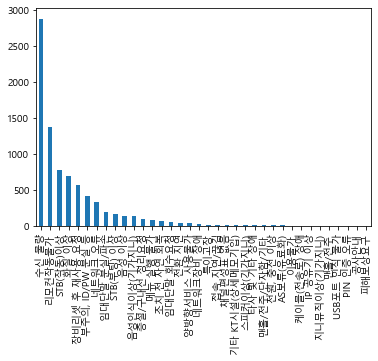

In [6]:
# depth_2 시각화

df['depth_2'].value_counts().plot(kind = 'bar')

###폰트 깨짐 방지###
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
###

#수치로 표현
print(df['depth_2'].value_counts())

택배발송              580
현장출동              453
M&S내방안내           212
부팅중 오류메시지 발생      151
기타문의              131
부팅지연(오류메시지 없음)     12
이용 불가(유선)           4
Name: depth_3, dtype: int64


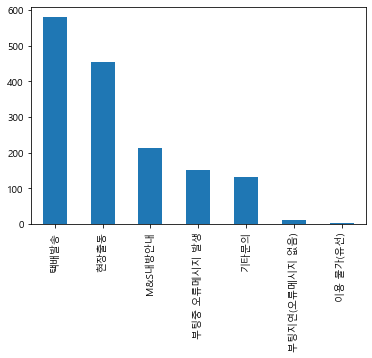

In [7]:
# depth_3 시각화
df['depth_3'].value_counts().plot(kind = 'bar')

###폰트 깨짐 방지###
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
###

#수치로 표현
print(df['depth_3'].value_counts())

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
result = le.fit_transform(df['depth_1'])
print(result)
print(le.classes_)

df['depth_1'] = result


[11  9  9 ...  9  9  3]
['AS접수/변경' 'VOD/컨텐츠' '고객원인' '단말' '데이터서비스' '리콜/손해배상' '부가/지능망서비스' '시설관리'
 '시설이전' '실시간 채널' '양방향서비스' '원인불명' '장애안내' '지니뮤직']


In [9]:
df.head()

,Label,sentence,depth_1,depth_2,depth_3
0,원인불명>조치 전 자연 회복,고객 요청사항 호안됨 상담 중 자연회복됨,11,조치 전 자연 회복,NaN
1,실시간 채널>네트워크 오류,고객 요청사항 호수신불인터넷 연결오류 뜸재부팅해 봄 모텔 영업용 일 중 꼭 점검원하...,9,네트워크 오류,NaN
2,실시간 채널>수신 불량,고객 요청사항 호수신불회선 단말특이사항 진단 결과 기타 추가 연락처 연후방,9,수신 불량,NaN
3,실시간 채널>네트워크 오류,수신 불 네트워크 오류 접수 보류,9,네트워크 오류,NaN
4,실시간 채널>수신 불량,고객 요청사항 수신불 연락 후 회선단말특이사항 진단 결과 기타 추가 연락처인 입,9,수신 불량,NaN


#### Train, Valid 데이터 셋 나누기

In [10]:
X = df['sentence']
y = df['depth_1']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [11]:
X_valid

757     고객 요청사항 전원 손띄면 꺼짐 스카치 테잎 임의 조치 중 리모컨도 고장 방문 시 ...
5015    티비에서 넷플릭스 유튜브 안됨 올인 홈 정상 인터넷 정상 티비 모두 정상으로 확인되...
1001    기가 지니에서 넷플릭스 실행 불가 리셋 권 유 고객 외부셔서 진행해 보시고 재연락 ...
8422                   일시 수신불 신호 없음 거실 티비 방에티비 번갈아가며 안 나옴
5259    고객 요청사항 재연결 해지 복구 임대장비 회수로 인하여 모뎀 및 회수 됨 장비 지 ...
                              ...                        
7662    차위성 수신 불량 올레 관시청 중 날씨 괜찮을 때도 해당 증상 있다고 점검 요미리 ...
4280    고객 요청사항 배우자리모컨 일부 버튼 작동 불교체회선 단말 특이사항 진단 결과 기타...
6838                               호 임의 네트워크 오류 셋탑리셋해도 동일
4613                                     리모컨 작동안 딤 직영점 안내
2573    코로나 이 상무재확인 필 고객 요청사항기가 지니 음성인식 안됨 회선 단말특이사항 진...
Name: sentence, Length: 1638, dtype: object

#### 불용어 처리 및 토큰화

- Okt 형태소 분석 도구를 이용하여 단어 토큰화를 진행함.
- stopwords를 직접 지정하여 제거하고 싶은 글자들을 선택
- for문을 구성하여 토큰화와 불용어처리를 한번에 진행
- 만들어야 하는 사전에 최대한 많은 단어를 담아야 하기 때문에 train, valid 나누지 않고 df_train라는 변수에 담음.

In [12]:
#불용어 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도', '를','으로','자','에',
'와','한','하다','을','에서','해서', '고객 요청사항', '안심권유', '안심권 유']

In [13]:
df_train = []

for row in df.iterrows() :   
    sentence = tokenizer.morphs(row[1]['sentence']) #단어 토큰화
    sentence = [word for word in sentence if not word in stopwords] #불용어 제거  
     
    df_train.append(sentence)

In [14]:
df_train[:3]

[['고객', '요청', '사항', '호안', '됨', '상담', '중', '자연', '회복', '됨'],
 ['고객',
  '요청',
  '사항',
  '호수',
  '신',
  '불',
  '인터넷',
  '연결',
  '오류',
  '뜸',
  '재부팅',
  '해',
  '봄',
  '모텔',
  '영업',
  '용',
  '일',
  '중',
  '꼭',
  '점검',
  '원하여',
  '지',
  '사이',
  '관함',
  '회선',
  '단말',
  '특이',
  '사항',
  '진단',
  '결과',
  '기타',
  '추가',
  '연락처'],
 ['고객',
  '요청',
  '사항',
  '호수',
  '신',
  '불',
  '회선',
  '단말',
  '특이',
  '사항',
  '진단',
  '결과',
  '기타',
  '추가',
  '연락처',
  '연',
  '후방']]

#### 사전(vocab) word_to_index 구성 및 스트링 변환

- 다양한 Tokenizer를 활용해서 데이터를 분석하기 위해 문자 데이터를 숫자로 바꿔줘야함
- Counter를 사용해도 되고, okt Tokenizer로 fit_on_texts를 사용해도 정수 인코딩을 할 수 있음
- word_to_index는 사전의 크기를 결정하는 인자이다. 따라서 words가 몇개 정도 있는지 보고 그에 따라 사전의 크기를 결정해주면 됨
- 사전 크기 또한 조절할 수 있는 부분이다. 하지만 너무 크게하면 학습이 느려진다.

- word_to_index는 key값이 텍스트 스트링이다. 따라서 인덱스 역할을 하는 key값을 숫자이기 때문에 해당 값에서 숫자를 추출하기 위한 함수가 필요하다. => wordlist_to_indexlist

In [15]:
words = np.concatenate(df_train).tolist()
len(words)

176526

In [16]:
vocab_size = 43800
counter = Counter(words)
counter = counter.most_common(vocab_size-4)
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

word_to_index = {word:index for index, word in enumerate(vocab)}

In [17]:
type(word_to_index)

dict

In [18]:
len(word_to_index)

5182

In [19]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '사항': 4,
 '요청': 5,
 '고객': 6,
 '추가': 7,
 '연락처': 8,
 '진단': 9,
 '결과': 10,
 '단말': 11,
 '특이': 12,
 '회선': 13,
 '기타': 14,
 '불': 15,
 '리모컨': 16,
 '리셋': 17,
 '방문': 18,
 '수신': 19,
 '코로나': 20,
 '확인': 21,
 '안': 22,
 '접수': 23,
 '후': 24,
 '함': 25,
 '작동': 26,
 '안됨': 27,
 '신': 28,
 '상무': 29,
 '시': 30,
 '안내': 31,
 '수': 32,
 '교체': 33,
 '시청': 34,
 '재': 35,
 '정상': 36,
 '티비': 37,
 '후방': 38,
 '타': 39,
 '연': 40,
 '필': 41,
 '선': 42,
 '화면': 43,
 '동일': 44,
 '셋탑': 45,
 '연락': 46,
 '점검': 47,
 '지니': 48,
 '재부팅': 49,
 '호': 50,
 '심': 51,
 '연결': 52,
 '기': 53,
 '일': 54,
 '정상기': 55,
 '중': 56,
 '인': 57,
 '됨': 58,
 '대': 59,
 '채널': 60,
 '빠른': 61,
 '하': 62,
 '이상': 63,
 '요': 64,
 '버튼': 65,
 '전원': 66,
 '나옴': 67,
 '임의': 68,
 '오류': 69,
 '택배': 70,
 '사용': 71,
 '고장': 72,
 '독촉': 73,
 '해도': 74,
 '전': 75,
 '신호': 76,
 '만': 77,
 '등록': 78,
 '배송': 79,
 '로': 80,
 '내': 81,
 '장비': 82,
 '다': 83,
 '건': 84,
 '외부': 85,
 '음성': 86,
 '불가': 87,
 '인터넷': 88,
 '없음': 89,
 '발송': 90,
 '화질': 91,
 '최대한

In [20]:
# 텍스트 스트링을 사전 인덱스 스트링으로 변환

def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

In [21]:
X_train = list(map(wordlist_to_indexlist, X_train))
X_valid = list(map(wordlist_to_indexlist, X_valid))

In [22]:
X_valid[:3]

[[118,
  227,
  2,
  64,
  891,
  416,
  308,
  2,
  75,
  125,
  2,
  630,
  2,
  228,
  2,
  1733,
  512,
  2,
  2156,
  2140,
  1410,
  2,
  3569,
  2,
  2,
  114,
  2,
  2,
  805,
  1410,
  2,
  56,
  2,
  288,
  2161,
  2372,
  2,
  2,
  118,
  162,
  2,
  185,
  474,
  2,
  30,
  2,
  3709,
  2,
  2,
  1683,
  1772,
  2,
  64,
  891],
 [108,
  270,
  2,
  333,
  2,
  1839,
  2785,
  2,
  2156,
  2,
  606,
  2,
  2,
  2,
  22,
  58,
  2,
  1679,
  57,
  2,
  120,
  2,
  482,
  178,
  2,
  57,
  2857,
  1839,
  2,
  482,
  178,
  2,
  108,
  270,
  2,
  2161,
  267,
  2,
  482,
  178,
  2,
  80,
  2,
  2297,
  57,
  540,
  441,
  2,
  118,
  227,
  2,
  360,
  2,
  108,
  270,
  80,
  2,
  2297,
  57,
  2,
  22,
  616],
 [53,
  2,
  2,
  152,
  356,
  2,
  333,
  2,
  1839,
  2785,
  2,
  2156,
  2,
  644,
  3214,
  2,
  15,
  2,
  2,
  288,
  102,
  2,
  477,
  2,
  606,
  2,
  118,
  227,
  2,
  332,
  652,
  4818,
  333,
  2,
  1048,
  3214,
  148,
  2,
  896,
  30,
  118,
  2,


#### 데이터 셋 내 문장 길이 분포

In [23]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[288, 2161, 2372, 2, 481, 150, 22, 2, 58, 2, 160, 4722, 2, 224, 2, 25]
라벨:  11
1번째 리뷰 문장 길이:  16
2번째 리뷰 문장 길이:  66


In [24]:
total_data_text = list(X_train) + list(X_valid)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

In [25]:
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  58.21903249450281
문장길이 최대 :  474
문장길이 표준편차 :  28.13411624330434


#### 적절한 문장 최대 길이 지정
- 분포를 통해 확인하여 문장 최대길이를 정해야함

리뷰의 최대 길이 : 474
리뷰의 평균 길이 : 58.21903249450281


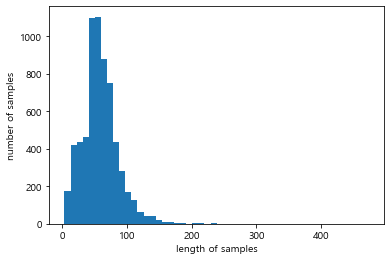

In [26]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 문장 최대길이가 114일때 전체 문장의 96%를 포함하는 것으로 보아 문장 최대길이는 114로 설정 MAX_LENTH = 114

In [27]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  114
전체 문장의 0.9651844612753482%가 maxlen 설정값 이내에 포함됩니다. 


#### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [28]:
X_train = pad_sequences(X_train, 
                        maxlen = max_len,
                        value=word_to_index["<PAD>"],
                        padding='pre')
X_valid = pad_sequences(X_valid, 
                       maxlen = max_len,
                       value=word_to_index["<PAD>"],
                       padding='pre')

In [29]:
print(X_train.shape)
print(X_valid.shape)

(6548, 114)
(1638, 114)


### Modeling

In [30]:
total_cnt = len(word_to_index)  # 어휘 사전의 크기입니다

print(total_cnt, '개')

5182 개


In [31]:
word_vector_dim = 50  

In [41]:
from tensorflow import keras

tf.random.set_seed(0)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
# model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(14, activation='softmax'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          2190000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1806      
Total params: 2,283,454
Trainable params: 2,283,454
Non-trainable params: 0
_________________________________________________________________


In [33]:
# validation set 29300건 분리
X_val = X_valid
y_val = y_valid

# validation set을 제외한 나머지 
partial_X_train = X_train
partial_y_train = y_train

print(partial_X_train.shape)
print(partial_y_train.shape)

(6548, 114)
(6548,)


In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('C:/Users/inp032/Desktop/채널 AI/channel-ai/model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [40]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60, # 512, 100, 60 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])
                    
model.save('C:/Users/inp032/Desktop/채널 AI/channel-ai/model/best_model.h5')                    

Epoch 1/20
110/110 [==============================] - 25s 209ms/step - loss: 0.6082 - accuracy: 0.8261 - val_loss: 0.6736 - val_accuracy: 0.8114
Epoch 2/20
110/110 [==============================] - 23s 208ms/step - loss: 0.5608 - accuracy: 0.8418 - val_loss: 0.6392 - val_accuracy: 0.8205
Epoch 3/20
110/110 [==============================] - 22s 203ms/step - loss: 0.5375 - accuracy: 0.8526 - val_loss: 0.6078 - val_accuracy: 0.8376
Epoch 4/20
110/110 [==============================] - 21s 194ms/step - loss: 0.4916 - accuracy: 0.8658 - val_loss: 0.5776 - val_accuracy: 0.8437
Epoch 5/20
110/110 [==============================] - 21s 188ms/step - loss: 0.4818 - accuracy: 0.8690 - val_loss: 0.6267 - val_accuracy: 0.8309
Epoch 6/20
110/110 [==============================] - 20s 183ms/step - loss: 0.4642 - accuracy: 0.8710 - val_loss: 0.5630 - val_accuracy: 0.8474
Epoch 7/20
110/110 [==============================] - 20s 181ms/step - loss: 0.4434 - accuracy: 0.8775 - val_loss: 0.5653 - val_ac

#### Loss, Accuracy 그래프 시각화

In [36]:
results = model.evaluate(X_valid,  y_valid, verbose=2)

print(results)

52/52 - 2s - loss: 0.7325 - accuracy: 0.8016
[0.7324643731117249, 0.8015872836112976]


In [37]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- 학습이 진행 될 수록 Loss 가 떨어짐.
- epoch을 더 늘려도 될 것 같다고 생각함.

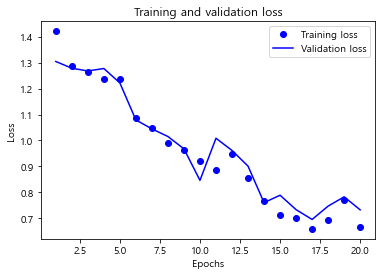

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
